# Оглавление
* [Описание проекта](#b1)
* [1. Загрузка и подготовка данных](#b2)
* [2. Обучение и проверка моделей](#b3)
* [3. Подготовка к расчёту прибыли](#b4)
* [4. Расчет рисков и прибыли](#b5)
* [5. Вывод (выбор региона)](#b6)

# Описание проекта<a class="anchor" id="b1"></a>

В добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. 

Шаги для выбора локации обычно такие:

* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль, проанализировать возможную прибыль и риски (техникой Bootstrap).


## Описание данных
Данные геологоразведки трёх регионов находятся в файлах: 
* /data/geo_data_0.csv
* /data/geo_data_1.csv
* /data/geo_data_2.csv 

где
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

## Дополнительные условия
1. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
2. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
3. Бюджет на разработку скважин в регионе — 10 млрд рублей.
4. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
6. Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
n = 3

# 1. Загрузка и подготовка данных<a class="anchor" id="b2"></a>

In [2]:
data = []
for i in range(n):
    data.append(pd.read_csv(f'data/geo_data_{i}.csv'))
    print(f'Регион {i}')
    print(data[i].describe())
    print(data[i].info())
    
    print('\n\n')
print('Общий вид таблиц')
print(data[0].head())

Регион 0
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64

Данные геологоразведки каждого региона содержат 100000 записей, пропусков нет, типы данных подобраны корректно. 

Все признаки, кроме идентификатора скважины, численные. Информация об идентификаторе скважины не влияет на прибыль от нее, поэтому избавимся от этого столбца

In [3]:
for i in range(n):
    data[i] = data[i].drop(['id'], axis=1)

В каждой таблице для каждой точки осталось 3 признака -- f0, f1 и f2 (неизвестно и неважно, что они означают), и 1 целевой признак -- product (объём запасов в скважине, тыс. баррелей).  Посмотрим еще раз на разброс значений признаков в каждой таблице

In [4]:
for i in range(n):
    print(f'Регион {i}')
    print(data[i].drop('product', axis=1).max() - data[i].drop('product', axis=1).min())
    print()

Регион 0
f0     3.770936
f1     2.191988
f2    28.092118
dtype: float64

Регион 1
f0    61.031331
f1    45.092661
f2     5.037865
dtype: float64

Регион 2
f0    15.998266
f1    14.928821
f2    28.709737
dtype: float64



Принято масштабировать те численные признаки, где разброс значений большой. В исходных датасетах это совсем не так, поэтому масштабирование никаким образом не повлияет на работу модели: не улучшит и не ухудшит. Тем более, нам неизвестно, что это за признаки, и мы не можем предугадать, какой признак более важен для предсказания целевого, а какой -- менее. Поэтому масштабировать признаки не будем.

# 2. Обучение и проверка моделей<a class="anchor" id="b3"></a>

#### 2.1. Для каждого региона разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

In [5]:
features_train = [0] * n
features_valid = [0] * n
target_train = [0] * n
target_valid = [0] * n

for i in range(n):
    features_train[i], features_valid[i], target_train[i], target_valid[i] = train_test_split(
        data[i].drop('product', axis=1), data[i]['product'], test_size=0.24, random_state=0
    )

#### 2.2. Для каждого региона обучим модель и сохраним предсказания на валидационной выборке

В условии сказано, что для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые). Поэтому ее и будем обучать

In [6]:
models = [0] * n
predicted_valid = [0] * n
for i in range(n):
    models[i] = LinearRegression()
    models[i].fit(features_train[i], target_train[i])
    predicted_valid[i] = pd.Series(models[i].predict(features_valid[i]))
    
    

#### 2.3 Для каждого региона подсчитаем средний запас предсказанного и реального сырья, а также RMSE модели

In [7]:
for i in range(n):
    print(f'Регион {i}')
    print(f'Средний запас: предсказанного сырья: {predicted_valid[i].mean()}, фактического сырья: {target_valid[i].mean()}')
    print(f'RMSE модели: {mean_squared_error(target_valid[i], predicted_valid[i], squared=False)}')
    print()

Регион 0
Средний запас: предсказанного сырья: 92.28265304242406, фактического сырья: 92.46668486161023
RMSE модели: 37.5075154581511

Регион 1
Средний запас: предсказанного сырья: 69.2617632106104, фактического сырья: 69.26524465980367
RMSE модели: 0.8873925934921435

Регион 2
Средний запас: предсказанного сырья: 94.72346468562912, фактического сырья: 95.38752066143222
RMSE модели: 40.31226535915305



*В среднем* модели достаточно близко предсказывают запасы сырья. При этом RMSE модели для 0 и 2 региона примерно одинаковые, тогда как для 1 региона, сравнительно с остальными, очень маленькая. Посмотрим еще раз на стандартные отклонения признаков в различных регионах, чтобы попробовать это объяснить.

In [8]:
for i in range(n):
    print(f'Регион {i}')
    print(data[i].describe().loc['std', ])
    print()

Регион 0
f0          0.871832
f1          0.504433
f2          3.248248
product    44.288691
Name: std, dtype: float64

Регион 1
f0          8.965932
f1          5.119872
f2          1.703572
product    45.944423
Name: std, dtype: float64

Регион 2
f0          1.732045
f1          1.730417
f2          3.473445
product    44.749921
Name: std, dtype: float64



Стандартные отклонения по целевому признаку product примерно равны, но что выделяет 1 регион -- сравнительно большие стандартные отклонения по f0 и f1. Возможно, ориентируясь именно на эти признаки, модели и удается так хорошо предсказывать целевой признак

# 3. Подготовка к расчёту прибыли<a class="anchor" id="b4"></a>

Все ключевые значения для расчётов (из условия) сохраним в отдельных переменных

In [9]:
total_points_amount = 500  # сколько всего точек исследуют при разведке региона
chosen_points_amount = 200  # сколько лучших точек выбирают 
budget = 10 * 10 ** 9  # стоимость разработки скважин в регионе
income_per_product = 450000  # доход с единицы продукта
alpha = 0.025  # оставляют лишь те регионы, в которых вероятность убытков меньше alpha*100 процентов 

Рассчитаем средний объём сырья с каждой новой скважины, достаточный для безубыточной разработки новых скважин 

In [10]:
min_mean_product = budget / (income_per_product * chosen_points_amount) 
print(min_mean_product)

111.11111111111111


Сравним полученный объём сырья со средним запасом в каждом регионе. 

In [11]:
for i in range(n):
    print(f'Средний запас скважин в регионе {i}: {target_valid[i].mean()}')

Средний запас скважин в регионе 0: 92.46668486161023
Средний запас скважин в регионе 1: 69.26524465980367
Средний запас скважин в регионе 2: 95.38752066143222


В каждом регине средний запас скважин меньше минимального для безубыточной разработки новых скважин. Можно сделать вывод, что регион и скважины нельзя выбирать "наугад" - в скважинах в любом из регионов в среднем объем сырья значительно меньше, чем достаточный объём сырья для безубыточной разработки новой скважины (в 1 региное - особенно). Поэтому нужно разработать метод выбора наиболее перспективных скважин и регионов.

Напишем функцию для расчёта прибыли по предсказаниям модели. На вход она принимает предсказания модели на некоторой выборке, отбирает лучшие скважины из этой выборк по предсказаниям модели, а затем считает доход от разработки выбранных скважин по **реальным** запасам.

In [12]:
def count_income(predicted_product, real_product, num_of_points_to_choose, income_per_product, budget):
    # выбираем из данны точек num_of_points_to_choose лучших по предсказанным запасам 
    chosen_indexes = predicted_product.sort_values(ascending=False)[:num_of_points_to_choose].index
    
    # суммируем запасы в них
    total_product_amount = real_product.iloc[chosen_indexes].sum()
    
    # рассчитываем прибыль при их разработке
    return total_product_amount * income_per_product - budget

# 4. Расчет рисков и прибыли<a class="anchor" id="b5"></a>

Для каждого региона техникой Bootstrap с 1000 выборок найдем распределение прибыли.

In [13]:
samples_amount = 1000
state = np.random.RandomState(12345) 
incomes = [[0] * samples_amount for region in range(n)]

for region in range(n):
    for i in range(samples_amount):
        predicted_subsample = predicted_valid[region].sample(n=total_points_amount, replace=False, random_state=state)
        income = count_income(predicted_subsample, target_valid[region], chosen_points_amount, income_per_product, budget)
        incomes[region][i] = income
            
incomes = pd.DataFrame(incomes)
incomes = incomes.transpose()
incomes.columns = [f'Регион {region}' for region in range(n)]
print('Распределения прибыли по регионам')
incomes

Распределения прибыли по регионам


,Регион 0,Регион 1,Регион 2
0,7.799155e+08,6.581902e+08,4.176045e+08
1,1.234789e+08,3.528512e+08,3.657129e+07
2,4.545795e+08,6.168273e+08,7.155666e+08
3,2.154485e+07,5.183650e+08,5.230562e+08
4,2.111870e+08,6.746110e+08,4.373971e+07
...,...,...,...
995,7.050101e+08,2.828764e+08,5.734087e+08
996,7.412724e+07,4.477682e+08,7.151744e+08
997,3.576354e+08,1.866533e+08,1.667739e+08
998,8.658439e+08,5.104656e+08,3.133591e+08


array([[<AxesSubplot:title={'center':'Регион 0'}>],
       [<AxesSubplot:title={'center':'Регион 1'}>],
       [<AxesSubplot:title={'center':'Регион 2'}>]], dtype=object)

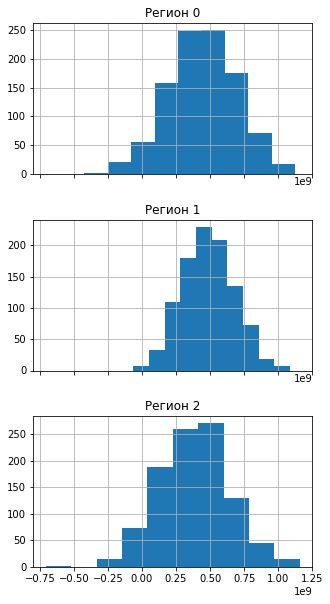

In [14]:
incomes.hist(figsize=(5, 10), layout=(3, 1), sharex=True)

<AxesSubplot:>

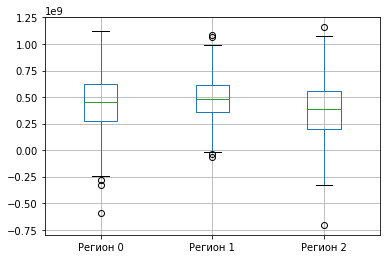

In [15]:
incomes.boxplot()

По гистограммам видно, что распределения похожи на нормальные. По всем графикам можно заметить, что средние и медианы прибыли во всех регионах примерно одного порядка. Но вот по гистограмме "ящик с усами" сразу заметно, что распределение в регионе 1 имеет меньшую дисперсию

Найдем среднюю прибыль, 95%-й доверительный интервал прибыли и риск убытков в каждом регионе

In [16]:
print('(В млн)')
incomes_mln = (incomes / 10 ** 6)
for region in range(n):
    print(f"Регион {region}. Средняя прибыль: {round(incomes_mln[f'Регион {region}'].mean())},",
          f"95%-й доверительный интервал: ({round(incomes_mln[f'Регион {region}'].quantile(0.025), 2)}, {round(incomes_mln[f'Регион {region}'].quantile(0.975), 2)}),",
          f"риск убытков: {100 * incomes_mln[incomes_mln[f'Регион {region}'] < 0][f'Регион {region}'].count() / samples_amount}%")

(В млн)
Регион 0. Средняя прибыль: 444, 95%-й доверительный интервал: (-65.54, 929.47), риск убытков: 4.3%
Регион 1. Средняя прибыль: 484, 95%-й доверительный интервал: (124.28, 863.03), риск убытков: 0.3%
Регион 2. Средняя прибыль: 384, 95%-й доверительный интервал: (-104.45, 924.25), риск убытков: 6.1%


# 5. Вывод (выбор региона)<a class="anchor" id="b6"></a>

Вероятность убытков меньше 2.5% только в 1 регионе. Наибольшая средняя прибыль - также 1 регионе, и с вероятностью в 95% разработка месторождений в нем принесет от 124 до 863 млн прибыли. 

Подобный результат можно объяснить тем, что модель, обученная для 1 региона, имела гораздо меньшее RMSE по сравнению с моделями для остальных регионов. Поэтому модель для первого региона чаще верно предсказывает, какие точки будут действительно содержать больше сырья, и удается выбрать наиболее удачные. Вероятно, скважины в этом регионе более "предсказуемые".


Таким образом, предлагается выбрать 1 регион.